<a href="https://colab.research.google.com/github/11PRIMUS/Early-Stage-Cancer-Prediction/blob/main/SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install image

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 80.9 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=6c22dc5eebf3964761523e7c4baf8a20ad57f2773d2d91fd0a316ee7b53289c4
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built image


In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [4]:
# Sample ROOT_DIR and number_of_images initialization
ROOT_DIR = "/content/drive/MyDrive/skinC/Skin cancer ISIC The International Skin Imaging Collaboration/Train"  # Define the correct dataset path
number_of_images = {dir: len(os.listdir(os.path.join(ROOT_DIR, dir))) for dir in os.listdir(ROOT_DIR)}

def dataFolder(p, split=0.7):
    # Check if the target folder exists
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)

        for dir in os.listdir(ROOT_DIR):
            # Create subdirectory in the new folder
            os.makedirs(os.path.join("./" + p, dir))

            # Select a random subset of images
            number_of_images_in_dir = len(os.listdir(os.path.join(ROOT_DIR, dir))) # Recalculate the number of images remaining
            sample_size = math.floor(split * number_of_images_in_dir)

            # Check if there are enough images for the sample
            if sample_size > number_of_images_in_dir:
                sample_size = number_of_images_in_dir # Use all remaining images if not enough for the sample

            selected_images = np.random.choice(
                a=os.listdir(os.path.join(ROOT_DIR, dir)),
                size=(sample_size),
                replace=False
            )

            # Copy selected images to the new location and delete originals
            for img in selected_images:
                original_path = os.path.join(ROOT_DIR, dir, img)
                destination_dir = os.path.join("./" + p, dir)

                if os.path.isfile(original_path):
                    shutil.copy(original_path, destination_dir)
                    os.remove(original_path)
    else:
        print(f"{p} folder already exists")

In [5]:
dataFolder("train")
dataFolder("val")
dataFolder("test")

In [6]:
def dataFolder(p, split=0.7):
    # Check if the target folder exists
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)

        for dir in os.listdir(ROOT_DIR):
            # Create subdirectory in the new folder
            os.makedirs(os.path.join("./" + p, dir))

            # Select a random subset of images
            number_of_images_in_dir = number_of_images[dir]
            selected_images = np.random.choice(
                a=os.listdir(os.path.join(ROOT_DIR, dir)),
                size=(math.floor(split * number_of_images_in_dir)),
                replace=False
            )

            # Copy selected images to the new location and delete originals
            for img in selected_images:
                original_path = os.path.join(ROOT_DIR, dir, img)
                destination_dir = os.path.join("./" + p, dir)

                if os.path.isfile(original_path):
                    shutil.copy(original_path, destination_dir)
                    os.remove(original_path)
    else:
        print(f"{p} folder already exists")

def preprocessingImages(path):
    image_data = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    print(f"Loading images from directory: {path}")

    if os.path.exists(path) and len(os.listdir(path)) > 0:
        image = image_data.flow_from_directory(
            directory=path,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
        )
        print(f"Class indices: {image.class_indices}")
        return image
    else:
        print(f"Error: Directory {path} does not exist or is empty.")
        return None

train_data = preprocessingImages("/content/train")
val_data = preprocessingImages("/content/val")
test_data = preprocessingImages("/content/test")

Loading images from directory: /content/train
Found 67 images belonging to 9 classes.
Class indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Loading images from directory: /content/val
Found 20 images belonging to 9 classes.
Class indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Loading images from directory: /content/test
Found 5 images belonging to 9 classes.
Class indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


In [7]:
# Load MobileNet model
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False

X = Flatten()(base_model.output)
X = Dense(units=9, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=X)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,680,457 (14.04 MB)

 Trainable params: 451,593 (1.72 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [8]:
# Define checkpoint
checkpoint = ModelCheckpoint('best.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=30,
    callbacks=[checkpoint]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.2281 - loss: 5.8151
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.4501 - loss: 7.0285
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 737ms/step - accuracy: 0.6668 - loss: 3.8449
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - accuracy: 0.8014 - loss: 2.3675
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 957ms/step - accuracy: 0.8533 - loss: 1.0133
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 734ms/step - accuracy: 0.8673 - loss: 0.8468
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 724ms/step - accuracy: 0.9559 - loss: 0.6677
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [10]:
# model graphical representation
h=history.history # Changed 'hist' to 'history'
h.keys()

dict_keys(['accuracy', 'loss'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: basal cell carcinoma (Probability: 0.9999)


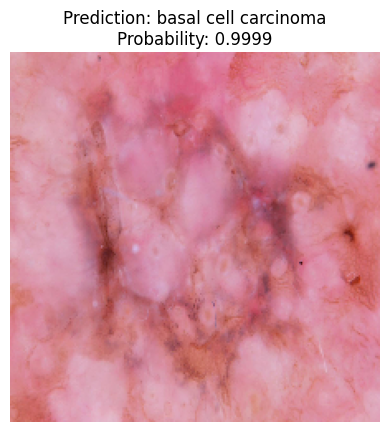

In [15]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image for prediction
path = "/content/test/actinic keratosis/ISIC_0030242.jpg"  # Ensure this path is correct
img = load_img(path, target_size=(224, 224))  # Resize the image to match the input shape

# Convert the image to an array and normalize it
input_arr = img_to_array(img) / 255.0  # Normalize the image (values between 0 and 1)
input_arr = np.expand_dims(input_arr, axis=0)  # Add batch dimension

# Predict the class probabilities
pred = model.predict(input_arr)
predicted_class = np.argmax(pred, axis=1)[0]  # Get the index of the highest probability

# Class labels (ensure these match the class order in your dataset)
class_labels = {
    0: 'keratosis',
    1: 'basal cell carcinoma',
    2: 'dermatofibroma',
    3: 'melanoma',
    4: 'nevus',
    5: 'pigmented benign keratosis',
    6: 'seborrheic keratosis',
    7: 'squamous cell carcinoma',
    8: 'vascular lesion'
}

# Print the prediction
predicted_label = class_labels[predicted_class]
predicted_prob = pred[0][predicted_class]
print(f"Predicted class: {predicted_label} (Probability: {predicted_prob:.4f})")

# Display the input image using matplotlib
plt.imshow(img)  # Display the original image
plt.title(f"Prediction: {predicted_label}\nProbability: {predicted_prob:.4f}")
plt.axis('off')  # Hide axis
plt.show()  # Display the image
